In [1]:
# This code is written by Yara Al-Shorman
# Date created: May 18 2022
# Last modified: Jun 2 2022
# Github repo: https://github.com/YaraAlShorman/Research-spring-22
# The purpose of this code is to predict the bulkflows for a large given set of galaxies (using machine learning)

### imports

In [13]:
# imports
import tensorflow as tf
from numpy import load, concatenate, expand_dims  # I am doing this to minimize unncessary imports, they take up too much RAM and time
from sklearn.preprocessing import MinMaxScaler
from math import floor
from matplotlib import pyplot as plt
# import matplotlib.pyplot as plt

### checking for GPU

### tangent: running tensorflow with GPU

Tensorflow by default attempts to run on GPU if possible. If the capability to do so was not found, it runs on the CPU. <br>
To allow it to run on the GPU and you are using an NVIDIA graphics card, you must download the THE CORRECT VERSIONS of CUDNN, CUDA, Tensorflow, and Python. <br>
Yes, all of them have to match up. (It took me 2 days to figure that out) <br>
To check if your NVIDIA GPU is compatible (I dont know if this works for AMD GPUs): Refer to https://developer.nvidia.com/cuda-gpus <br>
I have a GTX 1650 TI with Max-Q capability. Which is compatible.<br>
Furthermore, you must ensure you have matching versions of Python, Tensorflow, CUDNN and CUDA. <br>
No, having the newest versions is not enough. <br>
I installed: <br>
CUDNN v11.2 <br>
CUDA v8.1 <br>
Tensorflow v2.9 <br>
Python v3.10 <br>
You also need a compatible version of Visual Studio (MSVC). I have MSVC 2019. <br>
Keep in mind that the newest versions of CUDA and CUDNN are 8.4 and 11.7, respectively. Which will NOT work. Pay careful attention to versions. <br>
Refer to this page for compatible versions: https://www.tensorflow.org/install/source_windows#gpu <br>
Of course, things are different if you are using Mac or Linux <br>

In [ ]:
# checking that GPU is available
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### data preprocessing

In [3]:
# stacking all of the data into one humungous tensor
# I am using tensors because they can be ragged and can be stacked
# these means we won't have to cut off our data to standardize array sizes
data = load(f'C:/Users/yaras/Documents/Research/Feldman/rotated-outerrim-cz-rand/rotated-0-error-40.npy.npz')
input_data = data['data']
scaler = MinMaxScaler()
scaler.fit(input_data)
input_data = scaler.transform(input_data)
input_data = tf.expand_dims(input_data, axis=0)
input_data = tf.RaggedTensor.from_tensor(input_data)
# if scaling the data this way doesn't work good enough, i can try scaling all the data at once, to one scale
# in this case, i am scaling every 'square' of data seprately
# i should try scaling the entire 'cube' at once

output_data = tf.convert_to_tensor(data['header'])
output_data = tf.expand_dims(output_data, axis=0)

num_of_files = 100  # variable for number of files to load, current limit is 3000

for i in range(1, num_of_files): # limit 3000
        array_data = load(f'C:/Users/yaras/Documents/Research/Feldman/rotated-outerrim-cz-rand/rotated-{i}-error-40.npy.npz')
        # 'data' data
        temp = tf.convert_to_tensor(array_data['data'], dtype='float64')
        scaler = MinMaxScaler()
        scaler.fit(temp)
        temp = scaler.transform(temp)
        temp = tf.expand_dims(temp, axis=0)  # dimensions have to be expandad to be able to concat along the outer-dimension 
        input_data = tf.concat([input_data, temp], axis=0)  # concat adds to existing dimensions, does not create new ones
        # 'input_data' is a tensor
        
        # 'header' data (bulkflows)
        temp = array_data['header']
        temp = expand_dims(temp, axis=0)
        output_data = concatenate([output_data, temp], axis=0)
        # 'output_data' is an array, because it is uniform 
        # i scale it (normalize it) all at once, then i covnert it to a tensor
        
# next is scaling

In [4]:
# normalizing/scaling the data
scaler = MinMaxScaler()
scaler.fit(output_data)
output_data = scaler.transform(output_data)
output_data = tf.convert_to_tensor(output_data)

In [5]:
# splitting the data into train/test sections
# 75% -> train
# 25% -> test
train_percent = 0.75
input_train, input_test = (input_data[:floor(num_of_files * train_percent)], \
                                input_data[floor(num_of_files * train_percent)::])
output_train, output_test = (output_data[:floor(num_of_files * train_percent)], \
                                output_data[floor(num_of_files * train_percent)::])

# data is split and ready for the model

### model creation

In [8]:
# optimizer
# 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

In [9]:
# model creations

model0 = tf.keras.Sequential()
model0.add(tf.keras.layers.InputLayer(input_shape=[None, 4], ragged=True))
model0.add(tf.keras.layers.LSTM(512, dropout=0.25, activation='selu'))
model0.add(tf.keras.layers.Dense(128, activation='selu'))
model0.add(tf.keras.layers.Dropout(0.5))
model0.add(tf.keras.layers.Dense(32, activation='selu'))
model0.add(tf.keras.layers.Dropout(0.5))
model0.add(tf.keras.layers.Dense(16, activation='selu'))
model0.add(tf.keras.layers.Dropout(0.5))
model0.add(tf.keras.layers.Dense(3, activation='linear'))

model0.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['accuracy'])

a = model0.fit(input_train, output_train, epochs=20, use_multiprocessing=True, workers=8, verbose=2)



Epoch 1/20


ResourceExhaustedError: Graph execution error:

Detected at node 'sequential/lstm/while/Select_1' defined at (most recent call last):
    File "c:\Python310\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Python310\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "c:\Python310\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\Python310\lib\site-packages\traitlets\config\application.py", line 976, in launch_instance
      app.start()
    File "c:\Python310\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "c:\Python310\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "c:\Python310\lib\asyncio\base_events.py", line 600, in run_forever
      self._run_once()
    File "c:\Python310\lib\asyncio\base_events.py", line 1896, in _run_once
      handle._run()
    File "c:\Python310\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Python310\lib\site-packages\ipykernel\kernelbase.py", line 504, in dispatch_queue
      await self.process_one()
    File "c:\Python310\lib\site-packages\ipykernel\kernelbase.py", line 493, in process_one
      await dispatch(*args)
    File "c:\Python310\lib\site-packages\ipykernel\kernelbase.py", line 400, in dispatch_shell
      await result
    File "c:\Python310\lib\site-packages\ipykernel\kernelbase.py", line 724, in execute_request
      reply_content = await reply_content
    File "c:\Python310\lib\site-packages\ipykernel\ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "c:\Python310\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "c:\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "c:\Python310\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\yaras\AppData\Local\Temp\ipykernel_3716\2586876209.py", line 16, in <cell line: 16>
      a = model0.fit(input_train, output_train, epochs=20, use_multiprocessing=True, workers=8, verbose=2)
    File "c:\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "c:\Python310\lib\site-packages\keras\engine\training.py", line 1409, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Python310\lib\site-packages\keras\engine\training.py", line 1051, in train_function
      return step_function(self, iterator)
    File "c:\Python310\lib\site-packages\keras\engine\training.py", line 1040, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Python310\lib\site-packages\keras\engine\training.py", line 1030, in run_step
      outputs = model.train_step(data)
    File "c:\Python310\lib\site-packages\keras\engine\training.py", line 889, in train_step
      y_pred = self(x, training=True)
    File "c:\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "c:\Python310\lib\site-packages\keras\engine\training.py", line 490, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "c:\Python310\lib\site-packages\keras\engine\base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "c:\Python310\lib\site-packages\keras\engine\sequential.py", line 374, in call
      return super(Sequential, self).call(inputs, training=training, mask=mask)
    File "c:\Python310\lib\site-packages\keras\engine\functional.py", line 458, in call
      return self._run_internal_graph(
    File "c:\Python310\lib\site-packages\keras\engine\functional.py", line 596, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Python310\lib\site-packages\keras\layers\rnn\base_rnn.py", line 515, in __call__
      return super(RNN, self).__call__(inputs, **kwargs)
    File "c:\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "c:\Python310\lib\site-packages\keras\engine\base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "c:\Python310\lib\site-packages\keras\layers\rnn\lstm.py", line 574, in call
      last_output, outputs, states = backend.rnn(
    File "c:\Python310\lib\site-packages\keras\backend.py", line 4739, in rnn
      final_outputs = tf.compat.v1.while_loop(
    File "c:\Python310\lib\site-packages\keras\backend.py", line 4727, in _step
      flat_final_state = compute_masked_output(mask_t, flat_new_state,
    File "c:\Python310\lib\site-packages\keras\backend.py", line 4685, in compute_masked_output
      return tuple(
    File "c:\Python310\lib\site-packages\keras\backend.py", line 4686, in <genexpr>
      tf.compat.v1.where(mask_t, o, zo)
Node: 'sequential/lstm/while/Select_1'
OOM when allocating tensor with shape[32,512] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node sequential/lstm/while/Select_1}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_7449]

### testing & graphing results

In [10]:
output_pred = model0.predict(input_test)

1/1 [==============================] - 1s 1s/step


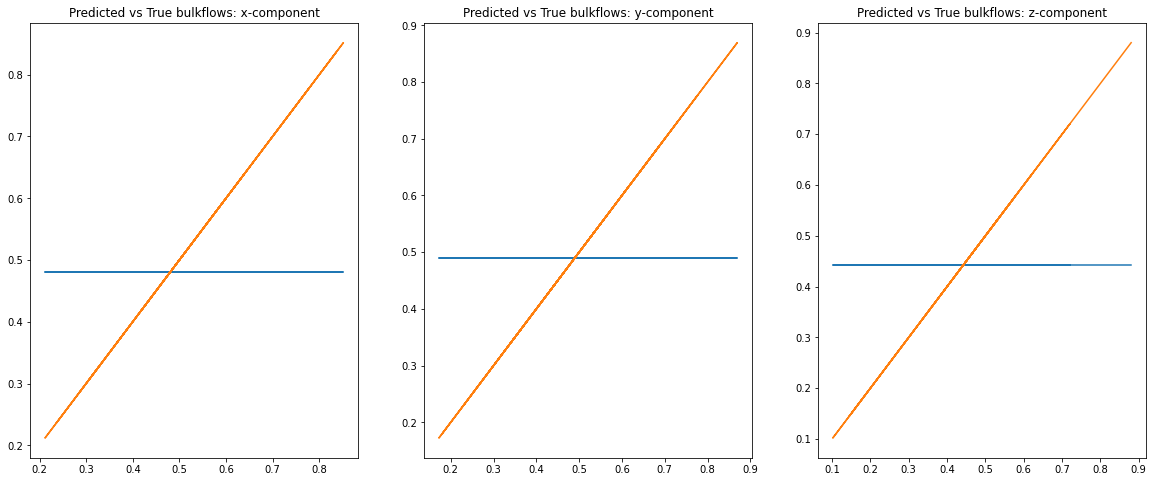

In [11]:
fig = plt.figure()
fig.set_figheight(8) 
fig.set_figwidth(20)

bx = fig.add_subplot(1, 3, 1)
plt.plot(output_test[:, 0], output_pred[:, 0])
plt.plot(output_test[:, 0], output_test[:, 0])
plt.title('Predicted vs True bulkflows: x-component')


by = fig.add_subplot(1, 3, 2)
plt.plot(output_test[:, 1], output_pred[:, 1])
plt.plot(output_test[:, 1], output_test[:, 1])
plt.title('Predicted vs True bulkflows: y-component')

bz = fig.add_subplot(1, 3, 3)
plt.plot(output_test[:, 2], output_pred[:, 2])
plt.plot(output_test[:, 2], output_test[:, 2])
plt.title('Predicted vs True bulkflows: z-component')

plt.show()